# Q learning

## data preprocessing

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df_or = pd.read_csv("ecommerce_sessions.csv")

df_or['tv_size_char'] = pd.cut(df_or['tv_size'], bins=3, labels=['small', 'medium', 'large'])
df_or['tv_price_char'] = pd.qcut(df_or['price'], q=3, labels=['cheap', 'medium', 'expensive'])

# Define the states as a combination of features
df_or['state'] = df_or[['tv_size_char', 'brand', 'resolution', 'tv_price_char']].apply(tuple, axis=1)

# Map actions to numerical values
action_map = {'view': 0, 'click': 1, 'purchase': 2}
df_or['action'] = df_or['action'].map(action_map)

# Assign rewards
reward_map = {0: 0, 1: 0, 2: 1}  # Only purchase gives a positive reward
df_or['reward'] = df_or['action'].map(reward_map)

In [3]:
df = df_or.copy()
display(df.head())

,session_id,user_id,tv_size,brand,resolution,price,action,timestamp,tv_size_char,tv_price_char,state,reward
0,1,487,55,BrandA,Full HD,1910,0,2024-11-04 03:00:04.497455,medium,expensive,"(medium, BrandA, Full HD, expensive)",0
1,2,716,40,BrandA,HD,1220,2,2024-11-04 19:35:04.498923,small,expensive,"(small, BrandA, HD, expensive)",1
2,3,1619,75,BrandA,HD,391,0,2024-11-24 23:11:04.499107,large,cheap,"(large, BrandA, HD, cheap)",0
3,4,1173,65,BrandD,Full HD,307,1,2024-11-08 09:46:04.499286,large,cheap,"(large, BrandD, Full HD, cheap)",0
4,5,1377,65,BrandD,4K,577,1,2024-11-19 16:20:04.499444,large,medium,"(large, BrandD, 4K, medium)",0


In [26]:
df_or[['tv_size_char', 'brand', 'resolution', 'tv_price_char']].drop_duplicates()

,tv_size_char,brand,resolution,tv_price_char
0,medium,BrandA,Full HD,expensive
1,small,BrandA,HD,expensive
2,large,BrandA,HD,cheap
3,large,BrandD,Full HD,cheap
4,large,BrandD,4K,medium
...,...,...,...,...
490,small,BrandC,HD,expensive
528,large,BrandA,4K,cheap
624,small,BrandD,8K,medium
625,small,BrandD,Full HD,cheap


In [4]:
# Initialize Q-table
states = df['state'].unique()
actions = [0, 1, 2]  # View, Click, Purchase
q_table = {state: {action: 0 for action in actions} for state in states}

In [5]:
# Hyperparameters
alpha = 0.1  # Learning rate, we can increase it to 0.2
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration rate it could be to 0.2

In [6]:
# Simulate episodes

# List to store Q-tables at each episode (if you want to track progress)
q_table_history = []
cumulative_rewards = []

for episode in tqdm(range(50000)):
    total_reward = 0

    # Randomly pick a session
    session = df.sample(1).iloc[0]
    state = session['state']
    action = np.random.choice(actions) if np.random.rand() < epsilon else max(q_table[state], key=q_table[state].get)

    reward = session['reward']
    total_reward += reward

    # To be introduced
    #epsilon = max(0.1, epsilon * 0.995)  # Gradually decay epsilon

    # Update Q-value
    next_state = session['state']  # Assume state transitions are self-contained here
    q_table[state][action] = q_table[state][action] + alpha * (
        reward + gamma * max(q_table[next_state].values()) - q_table[state][action]
    )

    # Save Q-table at every 1000th episode (or after each episode if desired)
    if episode % 1000 == 0:
        q_table_history.append(q_table.copy())  # Save a copy of the Q-table
    
    # Append the cumulative reward for this episode
    cumulative_rewards.append(total_reward) 

# Inspect learned policy
for state, actions in list(q_table.items())[:5]:
    print(f"State: {state}, Best Action: {max(actions, key=actions.get)}")

100%|██████████| 50000/50000 [02:08<00:00, 388.30it/s]

State: ('medium', 'BrandA', 'Full HD', 'expensive'), Best Action: 2
State: ('small', 'BrandA', 'HD', 'expensive'), Best Action: 0
State: ('large', 'BrandA', 'HD', 'cheap'), Best Action: 2
State: ('large', 'BrandD', 'Full HD', 'cheap'), Best Action: 2
State: ('large', 'BrandD', '4K', 'medium'), Best Action: 2


## Saving matrix

In [7]:
# Optionally save Q-table history to a file
with open('q_table_history.pkl', 'wb') as f:
    pickle.dump(q_table_history, f)

print("Q-table history saved.")


# Save Q-table to a file
with open("q_table.pkl", "wb") as f:
    pickle.dump(q_table, f)

print("Q-table saved successfully!")

Q-table history saved.
Q-table saved successfully!


## Loading matrix

In [8]:
# Load Q-table from a file
with open("q_table.pkl", "rb") as f:
    q_table = pickle.load(f)

print("Q-table loaded successfully!")

Q-table loaded successfully!


## Verifying loading matrix

In [9]:
# Print a sample state and its actions
for state, actions in list(q_table.items())[:5]:
    print(f"State: {state}, Actions: {actions}")

State: ('medium', 'BrandA', 'Full HD', 'expensive'), Actions: {0: 0.6945913473496473, 1: 0.6546682136303579, 2: 0.8931339153629503}
State: ('small', 'BrandA', 'HD', 'expensive'), Actions: {0: 0.7100638780191963, 1: 0.3731218443213882, 2: 0.4683997363398336}
State: ('large', 'BrandA', 'HD', 'cheap'), Actions: {0: 0.7942709699334491, 1: 0.7443038427385986, 2: 0.9150610399996347}
State: ('large', 'BrandD', 'Full HD', 'cheap'), Actions: {0: 0.6247072522562012, 1: 0.5711772322278736, 2: 1.1135838902980462}
State: ('large', 'BrandD', '4K', 'medium'), Actions: {0: 0.8578420850993526, 1: 0.6062871086499856, 2: 1.0329170958343556}


In [10]:
#q_table_dict = {'view': 0, 'click': 1, 'purchase': 2}
q_table_df = pd.DataFrame(list(q_table.items()), columns=['action', 'q_value'])
q_table_df.to_csv('q_table.txt', index=False)

## Plotting matrix

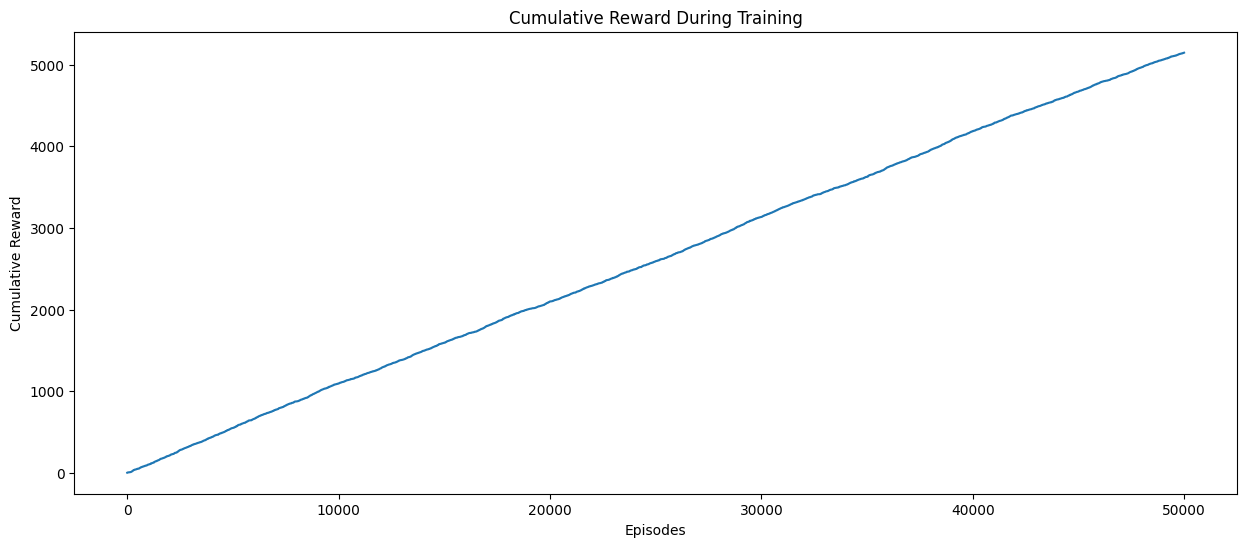

In [17]:
# Plot cumulative reward over episodes
plt.figure(figsize=(15, 6))
plt.plot(range(1, len(cumulative_rewards) + 1), np.cumsum(cumulative_rewards))
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward During Training')
plt.show()

In [18]:
# Assuming the Q-table has keys as states and actions, we can plot Q-values
episode_numbers = np.arange(0, len(q_table_history) * 1000, 1000)  # Episode numbers at which we saved Q-table

# Example: Plotting the Q-values for a specific state-action pair, say ('small', 'BrandC', 'HD', 'medium')
specific_state = ('small', 'BrandC', 'HD', 'medium')
q_values_for_specific_state = [q_table_history[i][specific_state] for i in range(len(q_table_history))]

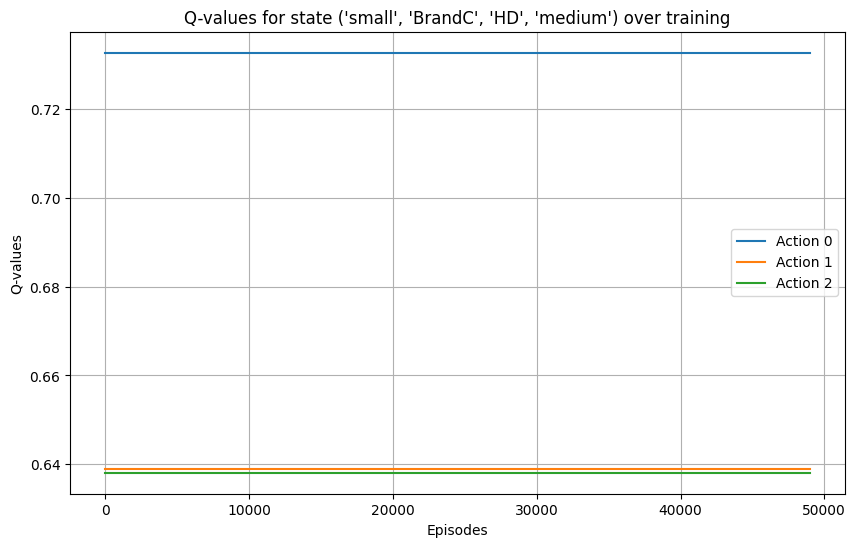

In [19]:
# Plot Q-values for each action (0, 1, 2) for the specific state
plt.figure(figsize=(10, 6))
actions = [0, 1, 2]  # View, Click, Purchase
for action in actions:
    plt.plot(episode_numbers, [q_values_for_specific_state[i][action] for i in range(len(q_values_for_specific_state))], label=f'Action {action}')
plt.xlabel('Episodes')
plt.ylabel('Q-values')
plt.title(f"Q-values for state {specific_state} over training")
plt.legend()
plt.grid(True)
plt.show()

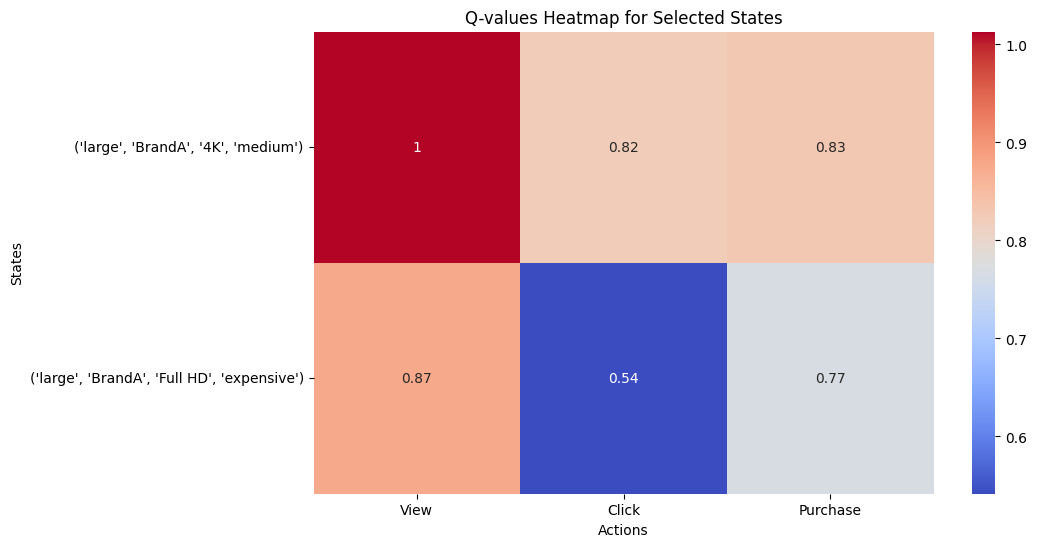

In [20]:
# Example: Convert Q-values for a subset of states into a 2D matrix for heatmap
state_subset = [('large', 'BrandA', '4K', 'medium'), ('large', 'BrandA', 'Full HD', 'expensive')]  # Subset of states

# Extract the Q-values for these states for each action
q_values_matrix = np.array([[q_table_history[-1][state][action] for action in [0, 1, 2]] for state in state_subset])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(q_values_matrix, annot=True, cmap='coolwarm', xticklabels=["View", "Click", "Purchase"], yticklabels=state_subset)
plt.title('Q-values Heatmap for Selected States')
plt.xlabel('Actions')
plt.ylabel('States')
plt.show()

## Future recommendations

In [21]:
tmp = df[['tv_size_char', 'brand', 'resolution', 'tv_price_char']].drop_duplicates().sample(1).values[0]
current_state = tuple(tmp)
current_state

('small', 'BrandB', '8K', 'medium')

In [22]:
if current_state in q_table:
    best_action = max(q_table[current_state], key=q_table[current_state].get)
    print(f"Best action for state {current_state}: {best_action}")
else:
    print(f"State {current_state} not found in Q-table.")

Best action for state ('small', 'BrandB', '8K', 'medium'): 1


### Handle Unseen States Gracefully

In [23]:
action_map_inv = {v: k for k, v in action_map.items()}

In [24]:
if current_state in q_table:
    best_action = max(q_table[current_state], key=q_table[current_state].get)
else:
    best_action = np.random.choice([0, 1, 2])  # Random action as fallback

print(f"Best action for state {current_state}: {action_map_inv[best_action]}")

Best action for state ('small', 'BrandB', '8K', 'medium'): click


In [25]:
if current_state not in q_table:
    q_table[current_state] = {0: 0, 1: 0, 2: 0}  # Default Q-values

best_action = max(q_table[current_state], key=q_table[current_state].get)
print(f"Best action for state {current_state}: {action_map_inv[best_action]}")

Best action for state ('small', 'BrandB', '8K', 'medium'): click
